In [30]:
import numpy as np
from sklearn import preprocessing
import pycasso
from sklearn.linear_model import lasso_path
from sklearn.linear_model import lars_path
from sklearn import linear_model
import time
import os

import pdb
from sklearn.metrics import accuracy_score

In [31]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "pic")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [32]:
def generate_sim_lognet(n, d, c, seed=1024):
  np.random.seed(seed)
  cor_X = c
  S = cor_X * np.ones((d, d)) + (1 - cor_X) * np.diag(np.ones(d))
  R = np.linalg.cholesky(S)

  X = np.dot(np.random.normal(size=n * d).reshape(n, d), R)
  X = preprocessing.scale(X) * np.sqrt(float(n - 1) / n)

  s = 20
  true_beta = np.zeros(d)
  true_beta[0:s] = np.random.uniform(low=0, high=1.0, size=s)

  # strictly seperable
  Y = np.random.binomial(1, 1 / (1 + np.exp(-np.dot(X, true_beta))))

  return (X, Y, true_beta)

In [33]:
def lognet_obj(X, Y, beta, intcpt, lamb):
  n, d = X.shape
  rp = np.dot(X, beta) + intcpt
#   return np.sum(np.log(1 + np.exp(rp)) - Y * rp) / n + lamb * np.sum(
#     np.abs(beta))
  return np.sum(np.log(1 + np.exp(rp)) - Y * rp)/n + lamb * np.sqrt(np.sum(
  np.square(beta)))

In [34]:
def x_Initialization(d):
    w = 5*np.zeros((1,d))
    return w 

In [35]:
def sigmoid_activation(result):
    final_result = 1/(1+np.exp(-result))
    return final_result

In [36]:
def model_optimize(w, X, Y):
    n, d = X.shape
    
    # Prediction
    final_result = sigmoid_activation(np.dot(w, X.T))
    Y_T = Y.T
    labd = np.sqrt(1/n)
#     labd = 0
    cost = (-1/n)*(np.sum((Y_T*np.log(final_result)) + ((1-Y_T)*(np.log(1-final_result))))) + labd*np.linalg.norm(w)
    
    # Gradient calculation
    dw = (1/n)*(np.dot(X.T, (final_result-Y.T).T)) + 2*labd*w
    
    grads = {"dw":dw}
    return grads, cost 

In [37]:

def model_predict(w,  X, Y, learning_rate, no_iterations):
    costs = []
    for i in range(no_iterations):
        #
        grads, cost = model_optimize(w,X,Y)
        #
        dw = grads["dw"]
        #weight update
        w = w - (learning_rate * (dw.T))
        #
        
        if (i % 50 == 0):
            costs.append(cost)
            #print("Cost after %i iteration is %f" %(i, cost))
    
    #final parameters
    coeff = {"w": w}
    gradient = {"dw": dw}
    
    return coeff, gradient, costs

In [38]:
def predict(final_pred, m):
    y_pred = np.zeros((1,m))
    for i in range(final_pred.shape[1]):
        if final_pred[0][i] > 0.5:
            y_pred[0][i] = 1
    return y_pred


In [47]:
X,Y,true_beta = generate_sim_lognet(50, 200, 0.1, seed=1024)
#Get number of features
n_features = X.shape[1]
print('Number of Features', n_features)
w = x_Initialization(n_features)
#Gradient Descent
coeff, gradient, costs = model_predict(w, X, Y, learning_rate=0.0001,no_iterations=100000)
#Final prediction
w = coeff["w"]
print('Optimized weights', w)
#
final_train_pred = sigmoid_activation(np.dot(w,X.T))
#
m_tr =  X.shape[0]
#
y_tr_pred = predict(final_train_pred, m_tr)
print('Training Accuracy',accuracy_score(y_tr_pred.T, Y))
#


/home/sophia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/sophia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


In [48]:
accuracy_score(y_tr_pred.T, Y)

0.8

In [49]:
np.linalg.norm(gradient['dw'])

31.460736156346904

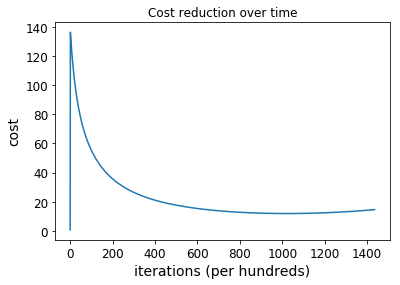

In [50]:
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title('Cost reduction over time')
plt.show()

In [14]:
import sys
from io import StringIO

In [15]:
old_stdout = sys.stdout
sys.stdout = mystdout = StringIO()
clf = linear_model.SGDClassifier(max_iter = 4500, tol=1e-6,loss='log', penalty ='l2')
clf.fit(X, Y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=4500,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=1e-06,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [16]:
y_tr_pred = clf.predict(X)
print('Training Accuracy',accuracy_score(y_tr_pred.T, Y))

In [17]:
accuracy_score(y_tr_pred, Y)

1.0

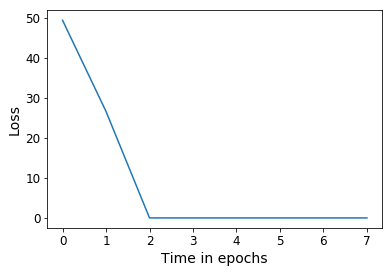

In [18]:
old_stdout = sys.stdout
sys.stdout = mystdout = StringIO()
clf = linear_model.SGDClassifier(max_iter = 4500, tol=1e-6,loss='log', penalty ='l2',verbose = 1)
clf.fit(X, Y)
sys.stdout = old_stdout
loss_history = mystdout.getvalue()
loss_list = []
for line in loss_history.split('\n'):
    if(len(line.split("loss: ")) == 1):
        continue
    loss_list.append(float(line.split("loss: ")[-1]))
plt.figure()
plt.plot(np.arange(len(loss_list)), loss_list)
plt.savefig("LR_L2_sklearn_pure_SGD:"+".png")
plt.xlabel("Time in epochs")
plt.ylabel("Loss")
plt.show()